> Cuál es el estado que más descuentos tiene en total? y en promedio? Supongan que de una direccion del estilo: 3123 Alan Extension Port Andrea, MA 26926, “MA” es el estado.

En esta caso vemos que existe el descuento tanto en el dataset de orders como en el de order_items. Vamos a suponer que el descuento que nos interesa es el del dataset de orders, ya que es el que tiene la información de la dirección.

In [35]:
import pandas as pd

df_orders = pd.read_pickle("../data/clean/orders.pkl")

df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4700000 entries, 1 to 4700000
Data columns (total 14 columns):
 #   Column            Dtype         
---  ------            -----         
 0   customer_id       Int64         
 1   order_date        datetime64[ns]
 2   status            category      
 3   payment_method    category      
 4   shipping_address  string        
 5   billing_address   string        
 6   discount_amount   Float64       
 7   tax_amount        Int64         
 8   shipping_cost     Float64       
 9   total_amount      Float64       
 10  currency          category      
 11  created_at        datetime64[ns]
 12  updated_at        datetime64[ns]
 13  subtotal          Int64         
dtypes: Float64(3), Int64(3), category(3), datetime64[ns](3), string(2)
memory usage: 470.6+ MB


Particularmente tiene la dirección de pago y la dirección de envío, vamos a hacer el análsis con ambas direcciones y de paso comparar los resultados.

In [36]:
df_orders = df_orders[
    ["shipping_address", "billing_address", "discount_amount", "total_amount"]
]
df_orders.describe()

,discount_amount,total_amount
count,3995000.0,3995000.0
mean,12.475941,24.996588
std,25.999769,14.436213
min,0.0,0.0
25%,0.0,12.49
50%,0.0,25.0
75%,0.0,37.49
max,100.0,50.0


In [37]:
df_orders.head()

,shipping_address,billing_address,discount_amount,total_amount
order_id,,,,
1,"49599 Wesley Burg Richardview, AZ 30649",USNV Morrison FPO AP 90901,0.0,25.96
2,"3123 Alan Extension Port Andrea, MA 26926","95271 Russell Spurs Apt. 613 West Marcus, ND 5...",0.0,43.36
3,"97369 Brown Cliff Apt. 811 Travisland, ME 61083",9341 VAZQUEZ COMMON SUITE 320 NEW ANTHONYMOUTH...,<NA>,48.59
4,"61010 Adams Ridges Stacymouth, CT 64105","830 Weiss River Suite 861 Lake Nicolemouth, DC...",18.83,1.39
5,"495 Fisher Forest Apt. 665 New Scott, AZ 18199","0635 teresa streets apt. 953 robertton, fm 83052",25.38,25.25


Como vemos el discount_amount es un float que se mueve entre 0 y 100 por lo que entendemos que se trata de un porcentaje. Sabiendo esto haremos el análisis para el porcentaje de descuento y para el descuento absoluto (total_amount * discount_amount / 100).

Para esto haremos transformaremos el dataset para ordenar los datos que necesitamos creando las siguientes columnas:
- state_shipping: estado de la dirección de envío (aplicando un regex para extraer las dos letras antes del código postal en shipping_address)
- state_billing: estado de la dirección de pago (aplicando un regex para extraer las dos letras antes del código postal en billing_address)
- discount_absolute: descuento absoluto (total_amount * discount_amount / 100)

In [38]:
import re

# Regex simple: coma, estado (2 letras), espacio y ZIP de 5 dígitos
pattern = re.compile(r",\s*([A-Z]{2})\s+\d{5}")

df_orders["state_shipping"] = df_orders["shipping_address"].str.extract(pattern)[0]
df_orders["state_billing"] = df_orders["billing_address"].str.extract(pattern)[0]

df_orders["state_shipping"] = df_orders["state_shipping"].astype("category")
df_orders["state_billing"] = df_orders["state_billing"].astype("category")

df_orders["discount_absolute"] = df_orders["total_amount"] * (
    df_orders["discount_amount"] / 100.0
)

df_orders = df_orders.drop(columns=["shipping_address", "billing_address"])
df_orders.head(10)

,discount_amount,total_amount,state_shipping,state_billing,discount_absolute
order_id,,,,,
1,0.0,25.96,AZ,<NA>,0.0
2,0.0,43.36,MA,ND,0.0
3,<NA>,48.59,ME,NJ,<NA>
4,18.83,1.39,CT,DC,0.261737
5,25.38,25.25,AZ,<NA>,6.40845
6,0.0,<NA>,PR,MN,<NA>
7,0.0,5.13,CA,WI,0.0
8,21.71,12.25,MO,OH,2.659475
9,0.0,13.18,SC,DC,0.0


Una vez tenemos las columnas, vamos a calcular los totales y promedios de descuento por estado para ambas direcciones y ver cuáles son los estados con más y menos descuentos.

El objetivo sería por cada estado:

- Cantidad de descuentos por shipping
- Cantidad de descuentos por billing

- Suma de abs_descuento por shipping
- Suma de abs_descuento por billing

- Promedio de abs_descuento por shipping
- Promedio de abs_descuento por billing

- Promedio de %descuento por shipping
- Promedio de %descuento por billing

In [39]:
grouped_by_shiping_state = (
    df_orders.groupby("state_shipping", observed=False)
    .agg(
        total_orders=("discount_absolute", "count"),
        total_discount=("discount_absolute", "sum"),
        avg_discount=("discount_amount", "mean"),
        avg_absolute_discount=("discount_absolute", "mean"),
    )
    .reset_index()
)

grouped_by_billing_state = (
    df_orders.groupby("state_billing", observed=False)
    .agg(
        total_orders=("discount_absolute", "count"),
        total_discount=("discount_absolute", "sum"),
        avg_discount=("discount_amount", "mean"),
        avg_absolute_discount=("discount_absolute", "mean"),
    )
    .reset_index()
)

In [40]:
grouped_by_shiping_state.describe()

,total_orders,total_discount,avg_discount,avg_absolute_discount
count,59.0,59.0,59.0,59.0
mean,44432.694915,138391.938272,12.470994,3.114633
std,206.591906,1757.88781,0.100723,0.03612
min,43980.0,134045.619685,12.249196,3.011246
25%,44293.5,137249.471215,12.402973,3.093476
50%,44449.0,138520.161253,12.458186,3.111744
75%,44589.0,139315.518201,12.541478,3.134651
max,44778.0,142554.094673,12.733434,3.225133


In [41]:
grouped_by_billing_state.describe()

,total_orders,total_discount,avg_discount,avg_absolute_discount
count,59.0,59.0,59.0,59.0
mean,44431.186441,138639.414385,12.484183,3.120344
std,225.43433,1763.582256,0.1217,0.038674
min,43899.0,134589.641042,12.241963,3.043362
25%,44283.5,137836.929558,12.397304,3.094901
50%,44440.0,138572.839459,12.475006,3.115561
75%,44615.0,139539.012681,12.555888,3.143733
max,44913.0,143624.403364,12.804961,3.229386


Por como vemos tanto en el caso de shipping_address como en billing_address, el desvío de los descuentos entre estados es muy pequeño.

En cantidad de descuentos por estado de envío la media es 44k y la desviación estándar de tan solo 0.2k, es decir la variación porcentual entre estados es practicamente nula... eso se clarisimamente en los máximos y en los mínimos, donde el máximo es 45k y el mínimo 43.8k una variación de un 2% de mínimo a máximo.

El análisis es muy similar para el caso de billing_address y también para los promedios y el total de descuento absoluto. El desvió estandar es varios ordenes de magnitud menor que la media y la variación entre el máximo y el mínimo es muy pequeña.

Para confirmar esta teoría veamos el TOP 3 y BOTTOM 3 de estados por descuento total, descuento promedio absoluto, descuento promedio porcentual y cantidad de descuentos, tanto para shipping_address como para billing_address.

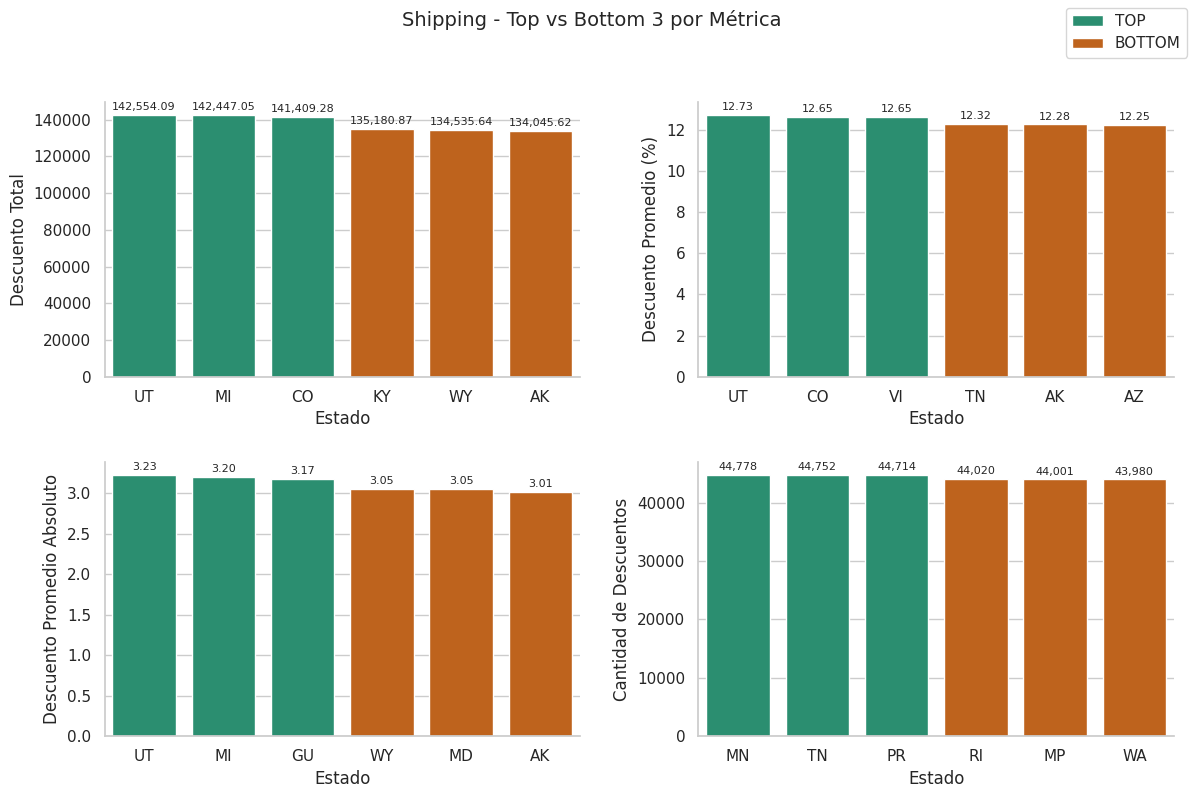

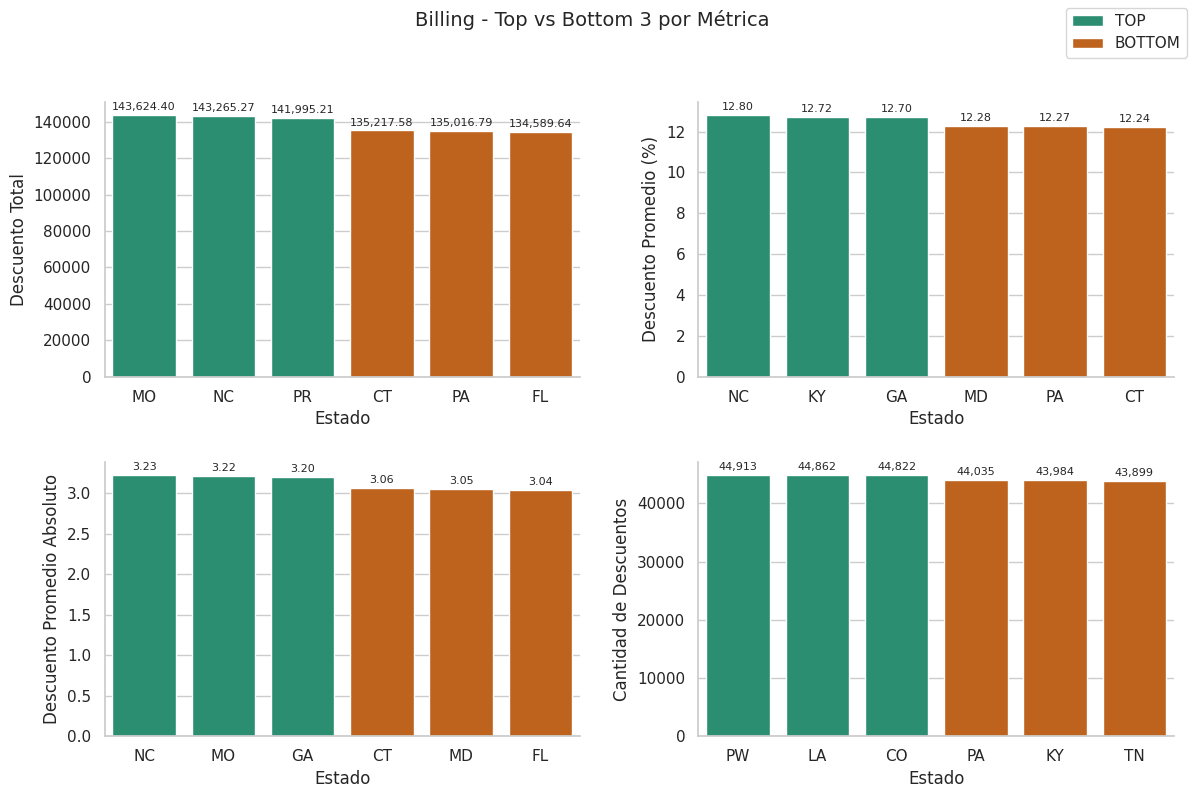

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configuración mínima
TOP_N = 3
metrics_cfg = [
    ("total_discount", "Descuento Total"),
    ("avg_discount", "Descuento Promedio (%)"),
    ("avg_absolute_discount", "Descuento Promedio Absoluto"),
    ("total_orders", "Cantidad de Descuentos"),
]

palette_map = {"TOP": "#1b9e77", "BOTTOM": "#d95f02"}
sns.set_theme(style="whitegrid")


def build_top_bottom(df, metric, state_col):
    sorted_df = df.sort_values(metric, ascending=False)
    
    top = sorted_df.head(TOP_N)[[state_col, metric]]
    bottom = sorted_df.tail(TOP_N)[[state_col, metric]]
    
    top["grupo"] = "TOP"
    bottom["grupo"] = "BOTTOM"
    
    merged = pd.concat([top, bottom], ignore_index=True).drop_duplicates(
        subset=[state_col]
    )
    # Pasar directo a string para evitar categorías sobrantes
    merged[state_col] = merged[state_col].astype(str)
    return merged


def draw_grid(df_src, state_col, titulo_general):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    for idx, (metric, title_metric) in enumerate(metrics_cfg):
        r = idx // 2
        c = idx % 2
        ax = axes[r, c]
        
        subset = build_top_bottom(df_src, metric, state_col).sort_values(
            metric, ascending=False
        )
        
        sns.barplot(
            data=subset,
            x=state_col,
            y=metric,
            hue="grupo",
            palette=palette_map,
            ax=ax,
        )
        
        ax.set_xlabel("Estado")
        ax.set_ylabel(title_metric)
        
        for container in ax.containers:
            values = container.datavalues
            lbls = [
                f"{v:,.2f}" if metric != "total_orders" else f"{v:,.0f}" for v in values
            ]
            ax.bar_label(container, labels=lbls, padding=2, fontsize=8)
            
        for spine in ["top", "right"]:
            ax.spines[spine].set_visible(False)

    # Leyenda única
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")
    for ax in axes.flat:
        ax.legend_.remove()
    fig.suptitle(titulo_general, fontsize=14, y=0.995)
    plt.tight_layout(rect=(0, 0, 1, 0.95), w_pad=2.0, h_pad=2.0)
    plt.show()



draw_grid(
    grouped_by_shiping_state, "state_shipping", "Shipping - Top vs Bottom 3 por Métrica"
)

draw_grid(
    grouped_by_billing_state, "state_billing", "Billing - Top vs Bottom 3 por Métrica"
)

Como vemos en los gráficos, podemos observar que la variación entre el Top 3 y el Bottom 3 es muy pequeño, por lo que podemos concluir que no hay un estado que tenga significativamente más descuentos que otro sin importar si medimos por estado de envío o de pago.